In [128]:
import matplotlib.pyplot as plt
from scipy.integrate import ode
import numpy as np

# Qubit Readout Simulation

Suppose the system consisting of a transmon and a readout resonator coupled in the dispersive regime. A transmission line couples with the resonator, whereby an operator can send input signals to the system and receive the transmitted waveform.

This notebook will simulate the emission of an input signal $s_{in}(t)$ along the transmission line, its interaction with the readout reasonator and the analysis of the transmitted waveform $s_{out}(t)$.

### Input signal

The input signal will be assumed to have the form

$$s_{in}(t) = A_{in}e^{i\phi_{in}}e^{-i\omega_{in} t} = (I_{in} + iQ_{in})e^{-i\omega_{in}t}.$$

$I_{in}$ and $Q_{in}$ are the in-phase and quadrature components of the phasor $A_{in}e^{i\phi_{in}}$.

The input signal is a coherent superposition of photons $\left|\beta_{in}\right\rangle$. The magnitude and phase of $\beta_{in}$ are directly related to $I_{in}$ and $Q_{in}$.

In [211]:
def b_in(t):

    # Pulse start time
    t0 = 100e-9
    
    # Pulse stop time
    tf = 1600e-9
    
    # Frequency mismatch between readout pulse and cavity (rad/s)
    omega_mm = 0
    
    if t > t0 and t < tf:
        return 1j*np.cos(2*np.pi*omega_mm*t)

    else:
        return 0 

### System evolution

Assume $\hat{a}$ is the annihilation operator of the readout resonator. In the Heisenberg-Langevin formulation, its equation of motion is

$$\frac{d}{dt}\hat{a} = \left(\pm i\frac{\chi}{2} - \frac{\kappa}{2}\right)\hat{a} -\sqrt{\kappa}\beta_{in}(t).$$

Note that this equation is written in a frame of reference with rotation $\omega_{in}$, assumed to be resonant with the resonator frequency. $\chi$ and $\kappa$ are the dispersive shift of the transmon-resonator coupling and the decay rate of photons leaking from the resonator to the tranmission line, respectively. The positive (negative) sign accompanying $\chi$ corresponds to the frequency shift induced by the transmon when it is in the ground (excited) state. Leakage to the environment is neglected.

Now assume the resonator is always in a coherent state $\left|\alpha(t)\right\rangle$. The evolution of $\alpha(t)$ is determined by the Langevin equation. Since $\hat{a}\left|\alpha(t)\right\rangle = \alpha(t)\left|\alpha(t)\right\rangle$,

$$\frac{d}{dt}\alpha(t) = \left(\pm i\frac{\chi}{2} - \frac{\kappa}{2}\right)\alpha(t) -\sqrt{\kappa}\beta_{in}(t).$$

This equation can be solved with standard methods to find $\alpha(t)$ as a function of $\beta_{in}(t)$.

In [212]:
g = 45e6 # Transmon-cavity coupling strength (Hz)
delta = 380e6 # Transmon-cavity detuning (0z)
chi = g**2/delta

kappa = chi

q_state = 0 # State of the transmon: 0 for ground and 1 for excited state

In [213]:
def eom_resonator(t, alpha, q_state, kappa, chi, b_in):
    return (1j*(-1)**q_state*chi/2 - kappa/2)*alpha - kappa**0.5*b_in(t)

t1 = 20/chi
dt = t1/1000
alpha0 = 0

q_state = 0

rg = ode(eom_resonator)
rg.set_integrator('zvode', method = 'bdf').set_initial_value(alpha0, 0).set_f_params(q_state, kappa, chi, b_in)
alpha_g = []
while rg.successful() and rg.t < t1:
    alpha_g.append(rg.integrate(rg.t + dt))
    
q_state = 1

re = ode(eom_resonator)
re.set_integrator('zvode', method = 'bdf').set_initial_value(alpha0, 0).set_f_params(q_state, kappa, chi, b_in)
alpha_e = []
while re.successful() and re.t < t1:
    alpha_e.append(re.integrate(re.t + dt))


In [214]:
t_rng = np.linspace(0, t1, 1000)
b_out_g = [kappa**0.5*alpha_g[x] + b_in(dt*x) for x in range(len(alpha_g))]
b_out_e = [kappa**0.5*alpha_e[x] + b_in(dt*x) for x in range(len(alpha_e))]

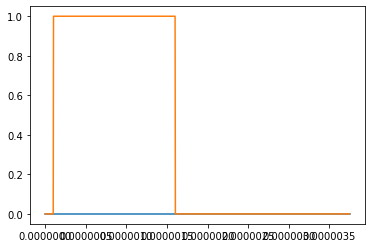

In [220]:
plt.plot([dt*x for x in range(len(alpha_g))], [b_in(dt*x).real for x in range(len(alpha_g))])
plt.plot([dt*x for x in range(len(alpha_g))], [b_in(dt*x).imag for x in range(len(alpha_g))])

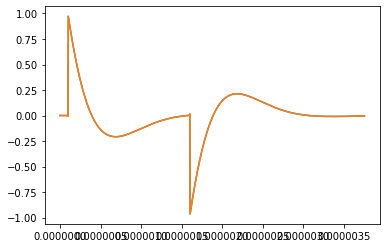

In [221]:
plt.plot(t_rng, [x.imag for x in b_out_e])
plt.plot(t_rng, [x.imag for x in b_out_g])